# Mission1

## Team. TakeOut

### wandb

In [ ]:
#wandb install
!pip install wandb
import wandb

#wandb login(you need api key)
wandb.login()

wandb: Currently logged in as: takeout. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="mission-1",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"final",
      # Track hyperparameters and run metadata
      config={
      "lr": 0.001,
      "batch_size": 64,
      "epochs": 50,
      })

config = wandb.config

### Connect Google mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Move dir location

In [ ]:
%cd /content/drive/MyDrive/데이터셋
%mkdir save_model
%ls

/content/drive/MyDrive/데이터셋
mkdir: cannot create directory ‘save_model’: File exists
 baseline.ipynb            save_model/
'Copy of mission2.ipynb'   train/
 kfood_health_train/       train_mean_std.npz
 kfood_health_val/         val/
 mission1.ipynb            validate_dist.ipynb
 mission2.ipynb            wandb/
 mission3.ipynb           '[대학부]딥러닝 모델 구현 실습 강채원.ipynb'


### Import package

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import unicodedata
from glob import glob
from PIL import Image

from tqdm.notebook import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
#from torch.utils.tensorboard import SummaryWriter#
from torchsummary import summary
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time

from torch.backends import cudnn
cudnn.benchmark = True

### matplotlib font setting
ref : https://mydevjourney.tistory.com/12

In [ ]:
# apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get update -qq

#나눔글꼴 설치
!apt-get install fonts-nanum* -qq

#파일 저장되어있는 경로와 이름 설정
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic')

# Matplotlib에 폰트 추가
fm.fontManager.ttflist.insert(0, fe)

#폰트설정
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})

# '-'기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] =False

### use cpu or gpu

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### set seed

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# For nomalization

### load mean and std

실행은 가능하나 ImageFolder에서 데이터를 가져오는 시간이 너무 길어서 train_mean_std.npz파일에 저장해놓고 사용했습니다.

In [ ]:
nor_transform = transforms.Compose([transforms.Resize((224, 224)),# 224by224로 resize
                                    transforms.ToTensor(),#img to tensor
                                    ])
for_normalization = ImageFolder('./train', transform=nor_transform)

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in tqdm(for_normalization)]#전체데이터의 평균(train에서만)
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in tqdm(for_normalization)]#전체데이터의 표준편차(train에서만)

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print("평균",meanR, meanG, meanB)
print("표준편차",stdR, stdG, stdB)

In [ ]:
meanR, meanG, meanB = 0.583938, 0.51390076, 0.4227201
stdR, stdG, stdB = 0.22708978, 0.2373795, 0.25375083

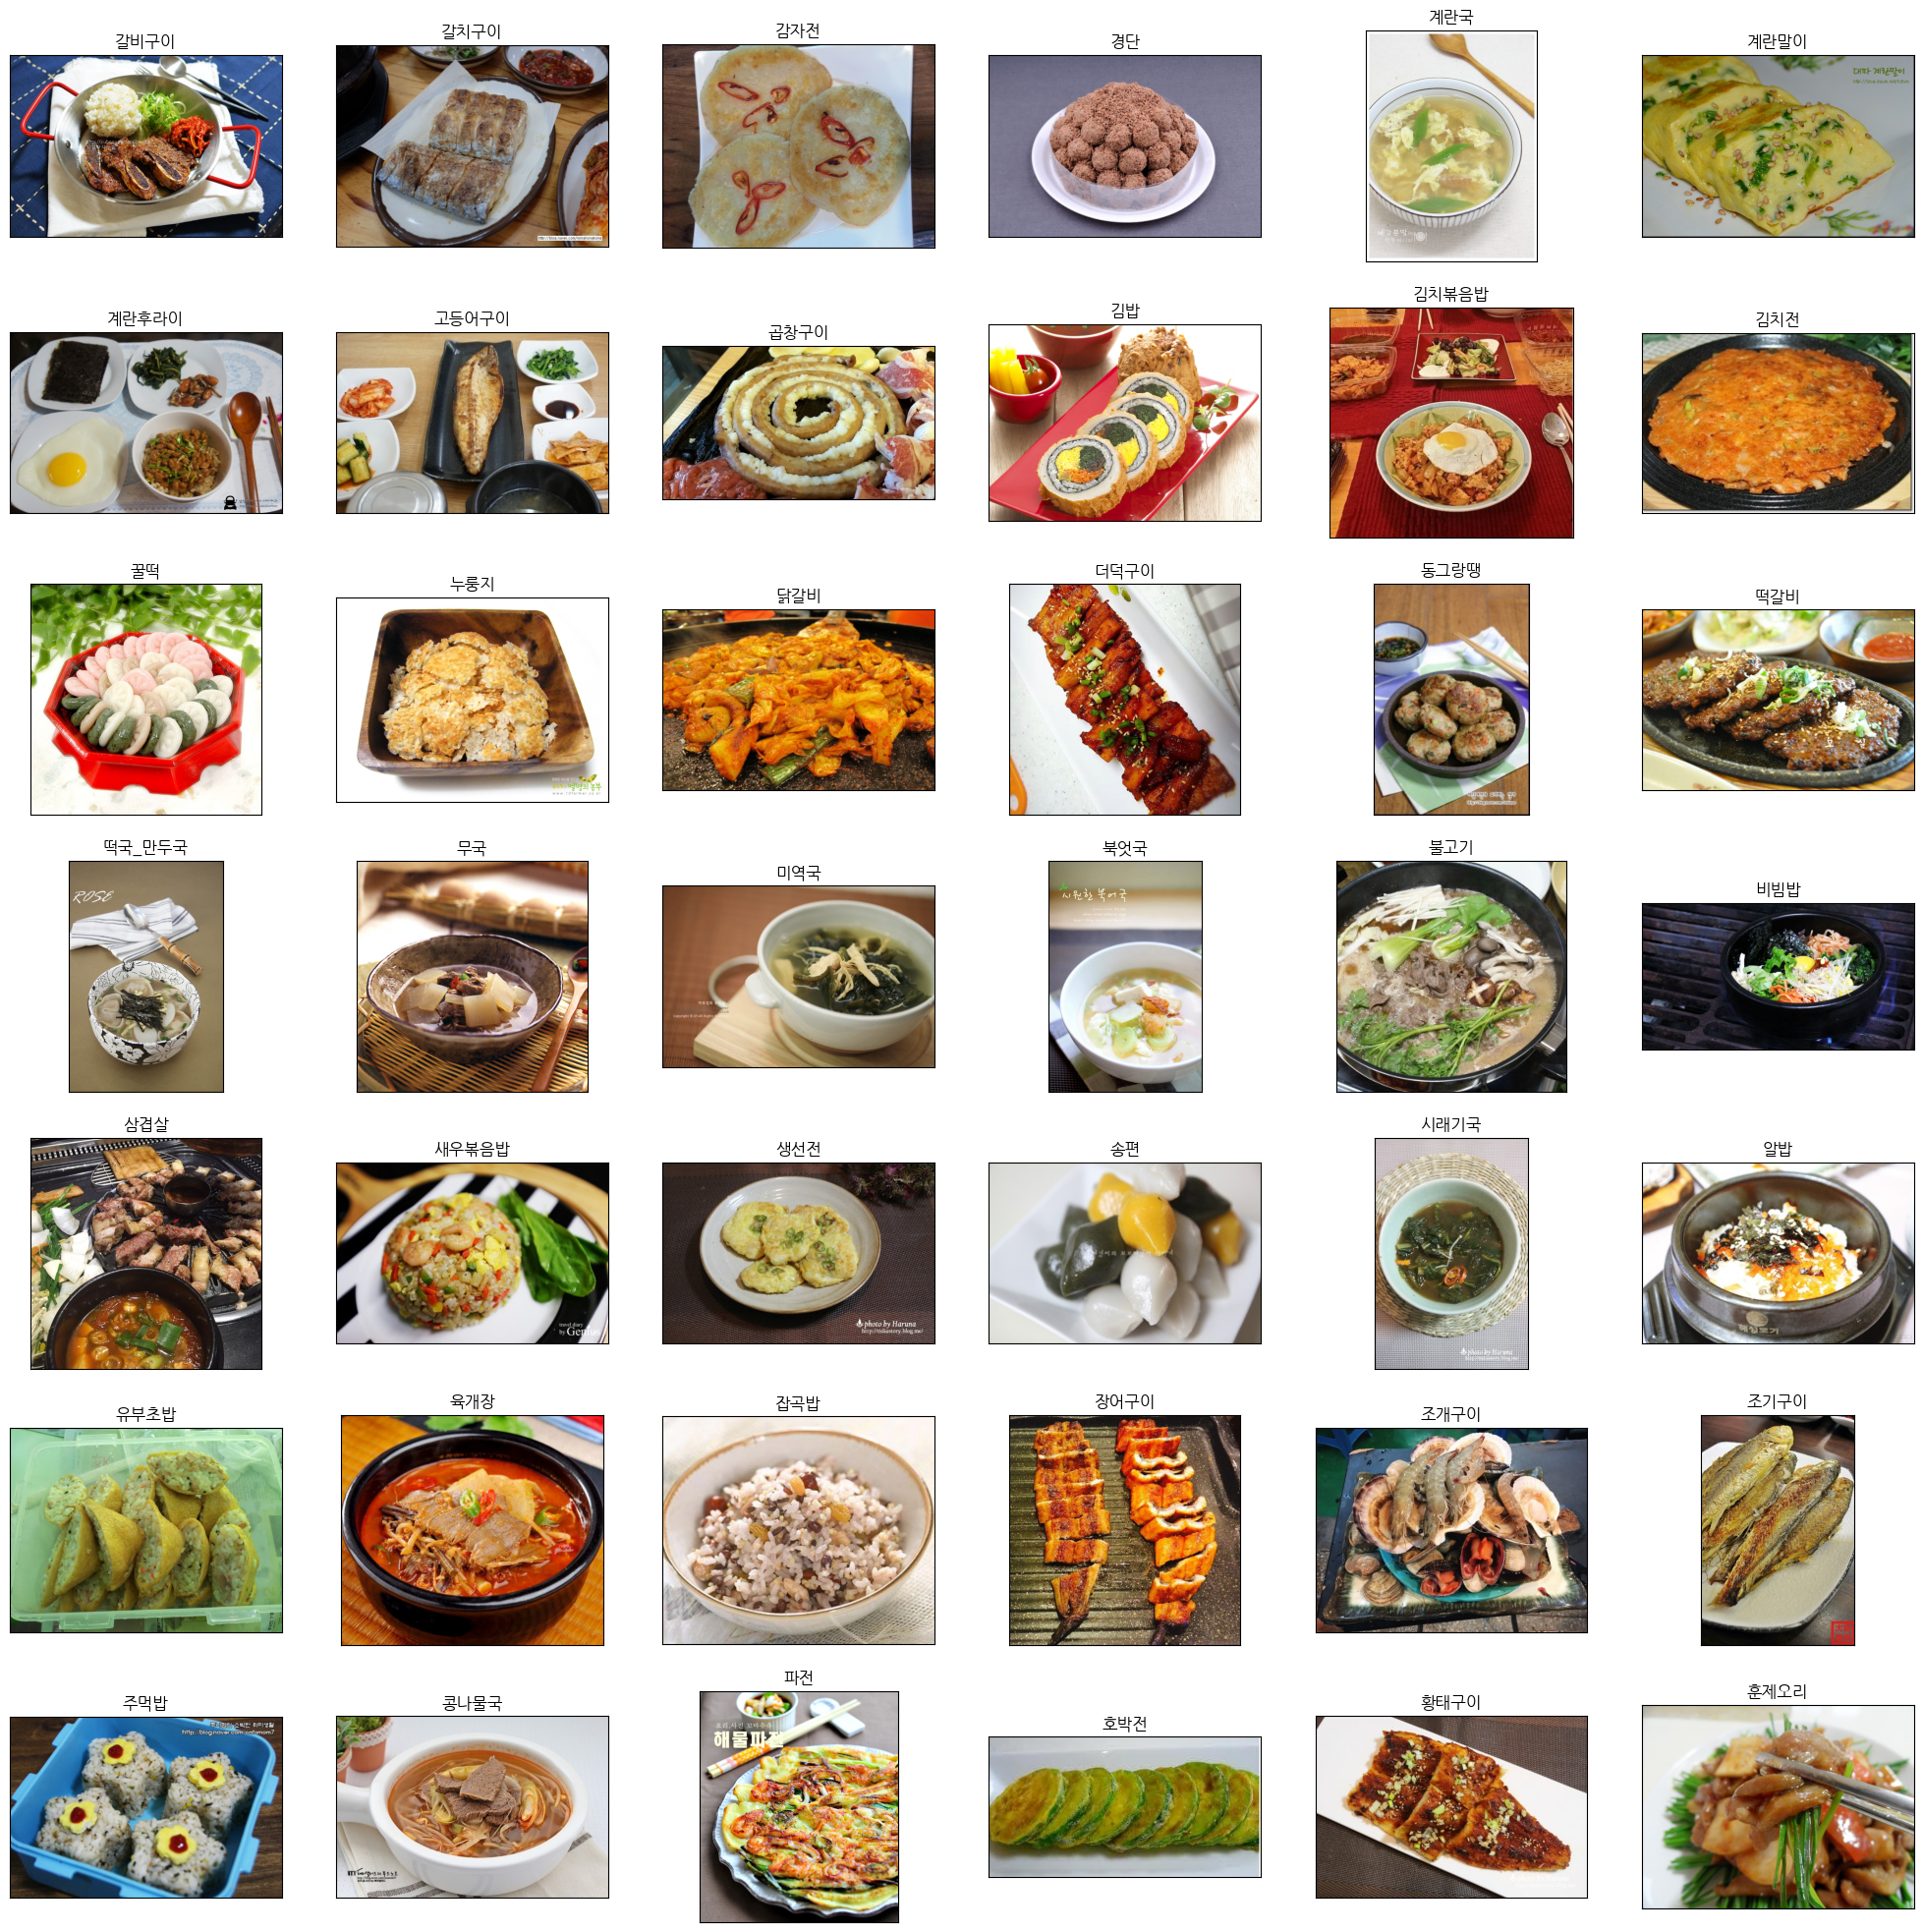

In [ ]:
#데이터를 불러옴
for_plot = ImageFolder('./train')
label_list = for_plot.classes

#각 라벨들의 데이터 개수를 구함
count = []
dt = glob('./train/*')
dt.sort()
for i, local in enumerate(dt):
  count.append(len(glob(f'{local}/*')))

#구한 데이터의 개수를 바탕으로 각 라벨들의 첫번째 이미지의 위치를 저장
count_list = [0]
for i in range(1,42):
  count_list.append(count_list[i-1] + count[i-1])
count_list = np.array(count_list) + 1

#plot 생성
fig, subplots = plt.subplots(7,6,figsize=(25, 25))

#plot안에 각각의 이미지를 그림
for i,num in enumerate(count_list):
    image,label = for_plot[num]
    ax = subplots.flat[i]
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(unicodedata.normalize('NFC',label_list[i]))

## DataLoad

https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [ ]:
#음식 데이터는 모양만큼 크기, 색도 중요하기 때문에 색과 관련된 변형은 넣어주지 않음.
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [meanR, meanG, meanB],std = [stdR, stdG, stdB])])

val_data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [meanR, meanG, meanB],std = [stdR, stdG, stdB])])

train_data = ImageFolder('./train', transform=data_transform)
val_data = ImageFolder('./val', transform=val_data_transform)

In [ ]:
train_loader = DataLoader(train_data,
                          batch_size=config.batch_size,
                          shuffle=True,
                          num_workers=8,)

val_loader = DataLoader(val_data,
                        batch_size=config.batch_size,
                        shuffle=False,
                        num_workers=8)

### model generation

In [ ]:
resnet = models.resnet18(pretrained=False)
fc_in_features = resnet.fc.in_features
resnet.fc = nn.Linear(fc_in_features,len(label_list))
resnet = resnet.to(device)

### loss_function and optimizer generation

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=config.lr, momentum=0.9)

In [ ]:
resnet.to(device)
print('not print model arch')

not print model arch


In [ ]:
max_val_corr = 0

In [ ]:
#start training
for epoch in range(config.epochs):
  resnet.train()
  training_loss = 0.0

  #training part
  for inputs, labels in tqdm(train_loader,leave=False):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = resnet(inputs)
    loss = criterion(outputs, labels)
    preds = torch.argmax(outputs, 1)

    loss.backward()
    optimizer.step()

    training_loss += loss.item()

  #validation part
  with torch.no_grad():
    resnet.eval()
    running_loss = 0.0
    accuracies = []

    for inputs, labels in tqdm(val_loader,leave=False):
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = resnet(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)

      running_loss += loss.item()
      accuracies.append(preds == labels)
    accuracy = torch.concat(accuracies).float().mean() * 100
    rate_acc = accuracy.item()
    print(f'epoch: {epoch} \t train_loss: {training_loss:.4f} \t val_loss: {running_loss:.4f} \t val_corr: {rate_acc:.4f}%')
    wandb.log({'train/loss':training_loss,'val/loss':running_loss,'val/corr':rate_acc})

    if rate_acc > max_val_corr:
      if os.path.isfile(f'./save_model/best_model(mission1-{max_val_corr:.4f}).pt'):
        os.remove(f'./save_model/best_model(mission1-{max_val_corr:.4f}).pt')
      PATH = f'./save_model/best_model(mission1-{rate_acc:.4f}).pt'
      torch.save(resnet.state_dict(), PATH)
      max_val_corr = rate_acc

  print("ㅡ"*60)

print("END")

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 0 	 train_loss: 1730.4910 	 val_loss: 211.4920 	 val_corr: 13.5007%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 1 	 train_loss: 1495.6072 	 val_loss: 181.3279 	 val_corr: 23.1881%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 2 	 train_loss: 1360.3208 	 val_loss: 161.4065 	 val_corr: 30.3648%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 3 	 train_loss: 1247.0963 	 val_loss: 155.7208 	 val_corr: 32.5675%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 4 	 train_loss: 1151.4169 	 val_loss: 145.6043 	 val_corr: 36.3335%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 5 	 train_loss: 1076.0577 	 val_loss: 142.1501 	 val_corr: 37.3520%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 6 	 train_loss: 1013.7827 	 val_loss: 135.4799 	 val_corr: 39.5784%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 7 	 train_loss: 963.9711 	 val_loss: 130.9892 	 val_corr: 41.4259%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 8 	 train_loss: 915.1684 	 val_loss: 144.9443 	 val_corr: 37.5415%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 9 	 train_loss: 879.0893 	 val_loss: 116.2171 	 val_corr: 47.8920%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 10 	 train_loss: 841.3937 	 val_loss: 119.4262 	 val_corr: 46.8261%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 11 	 train_loss: 808.1570 	 val_loss: 106.1061 	 val_corr: 52.2501%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 12 	 train_loss: 777.1932 	 val_loss: 108.1213 	 val_corr: 51.1606%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 13 	 train_loss: 747.6771 	 val_loss: 107.7781 	 val_corr: 51.7764%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 14 	 train_loss: 721.6314 	 val_loss: 109.8010 	 val_corr: 51.7527%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 15 	 train_loss: 699.2879 	 val_loss: 96.8735 	 val_corr: 55.5661%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 16 	 train_loss: 668.9205 	 val_loss: 99.5976 	 val_corr: 55.0450%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 17 	 train_loss: 651.5047 	 val_loss: 96.0791 	 val_corr: 56.3240%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 18 	 train_loss: 626.2110 	 val_loss: 88.5545 	 val_corr: 59.2136%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 19 	 train_loss: 610.0418 	 val_loss: 96.0284 	 val_corr: 56.1582%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 20 	 train_loss: 588.1905 	 val_loss: 92.2364 	 val_corr: 58.5268%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 21 	 train_loss: 567.7875 	 val_loss: 93.5724 	 val_corr: 57.8636%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 22 	 train_loss: 550.2042 	 val_loss: 86.2056 	 val_corr: 60.0663%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 23 	 train_loss: 530.2815 	 val_loss: 87.3252 	 val_corr: 58.9531%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 24 	 train_loss: 514.4857 	 val_loss: 90.5120 	 val_corr: 59.0952%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 25 	 train_loss: 497.3245 	 val_loss: 84.1062 	 val_corr: 62.1270%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 26 	 train_loss: 480.2974 	 val_loss: 83.5517 	 val_corr: 61.6296%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 27 	 train_loss: 464.1380 	 val_loss: 79.3517 	 val_corr: 63.1928%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 28 	 train_loss: 447.7441 	 val_loss: 79.3232 	 val_corr: 63.5481%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 29 	 train_loss: 434.1658 	 val_loss: 77.2883 	 val_corr: 64.4008%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 30 	 train_loss: 415.1596 	 val_loss: 88.2699 	 val_corr: 60.7769%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 31 	 train_loss: 402.3813 	 val_loss: 82.6935 	 val_corr: 62.6243%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 32 	 train_loss: 387.7543 	 val_loss: 80.9775 	 val_corr: 63.8797%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 33 	 train_loss: 372.5300 	 val_loss: 85.4678 	 val_corr: 61.7954%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 34 	 train_loss: 361.2422 	 val_loss: 78.7494 	 val_corr: 64.7560%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 35 	 train_loss: 346.8565 	 val_loss: 81.1878 	 val_corr: 64.4481%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 36 	 train_loss: 338.0996 	 val_loss: 86.7372 	 val_corr: 62.5296%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 37 	 train_loss: 316.7367 	 val_loss: 85.4136 	 val_corr: 62.6717%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 38 	 train_loss: 307.6352 	 val_loss: 80.3452 	 val_corr: 64.6376%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 39 	 train_loss: 299.8502 	 val_loss: 83.2512 	 val_corr: 64.6613%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 40 	 train_loss: 283.1202 	 val_loss: 81.4983 	 val_corr: 65.2298%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 41 	 train_loss: 272.4466 	 val_loss: 84.3201 	 val_corr: 64.1165%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 42 	 train_loss: 259.7334 	 val_loss: 84.4482 	 val_corr: 64.8981%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 43 	 train_loss: 253.2249 	 val_loss: 84.5371 	 val_corr: 64.6139%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 44 	 train_loss: 233.2932 	 val_loss: 78.6462 	 val_corr: 66.0587%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 45 	 train_loss: 226.1318 	 val_loss: 76.1658 	 val_corr: 67.7878%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 46 	 train_loss: 214.9237 	 val_loss: 76.9116 	 val_corr: 68.1431%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 47 	 train_loss: 202.0833 	 val_loss: 73.6094 	 val_corr: 69.0905%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 48 	 train_loss: 196.4720 	 val_loss: 77.6503 	 val_corr: 67.9299%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

epoch: 49 	 train_loss: 188.9007 	 val_loss: 77.9210 	 val_corr: 67.2667%
ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
END


### model load

In [ ]:
resnet = models.resnet18(pretrained=False)
fc_in_features = resnet.fc.in_features
resnet.fc = nn.Linear(fc_in_features,len(label_list))

resnet.load_state_dict(torch.load(PATH))
resnet.to(device)
print('not print model arch')

not print model arch


In [ ]:
temp = [[0]*len(label_list)]*len(label_list)
temp_tensor = torch.tensor(temp)

In [ ]:
correct_pred = {classname: 0 for classname in label_list}
total_pred = {classname: 0 for classname in label_list}

accuracies = []

temp = [[0]*len(label_list)]*len(label_list)
temp_tensor = torch.tensor(temp).to(device)
metric = MulticlassConfusionMatrix(len(label_list)).to(device)

with torch.no_grad():
  resnet.eval()

  for inputs, labels in tqdm(val_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = resnet(inputs)
    preds = torch.argmax(outputs, dim=1)
    temp_tensor += metric(preds, labels)
    accuracies.append(preds == labels)

    for img, label, pred in zip(inputs, labels, preds):
      if label == pred:
        correct_pred[label_list[label]] += 1
      total_pred[label_list[label]] += 1

accuracy = torch.concat(accuracies).float().mean() * 100
print(f'채점 점수 : {accuracy.item()}')
print('-'*50)
for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname} \t is {accuracy:.2f}%')

  0%|          | 0/66 [00:00<?, ?it/s]

채점 점수 : 69.0904769897461
--------------------------------------------------
Accuracy for class: 갈비구이 	 is 55.29%
Accuracy for class: 갈치구이 	 is 79.80%
Accuracy for class: 감자전 	 is 47.47%
Accuracy for class: 경단 	 is 65.96%
Accuracy for class: 계란국 	 is 84.54%
Accuracy for class: 계란말이 	 is 66.36%
Accuracy for class: 계란후라이 	 is 70.71%
Accuracy for class: 고등어구이 	 is 63.44%
Accuracy for class: 곱창구이 	 is 62.14%
Accuracy for class: 김밥 	 is 78.38%
Accuracy for class: 김치볶음밥 	 is 65.31%
Accuracy for class: 김치전 	 is 66.09%
Accuracy for class: 꿀떡 	 is 81.73%
Accuracy for class: 누룽지 	 is 78.57%
Accuracy for class: 닭갈비 	 is 60.00%
Accuracy for class: 더덕구이 	 is 71.58%
Accuracy for class: 동그랑땡 	 is 47.62%
Accuracy for class: 떡갈비 	 is 64.57%
Accuracy for class: 떡국_만두국 	 is 76.53%
Accuracy for class: 무국 	 is 76.52%
Accuracy for class: 미역국 	 is 84.69%
Accuracy for class: 북엇국 	 is 73.26%
Ac

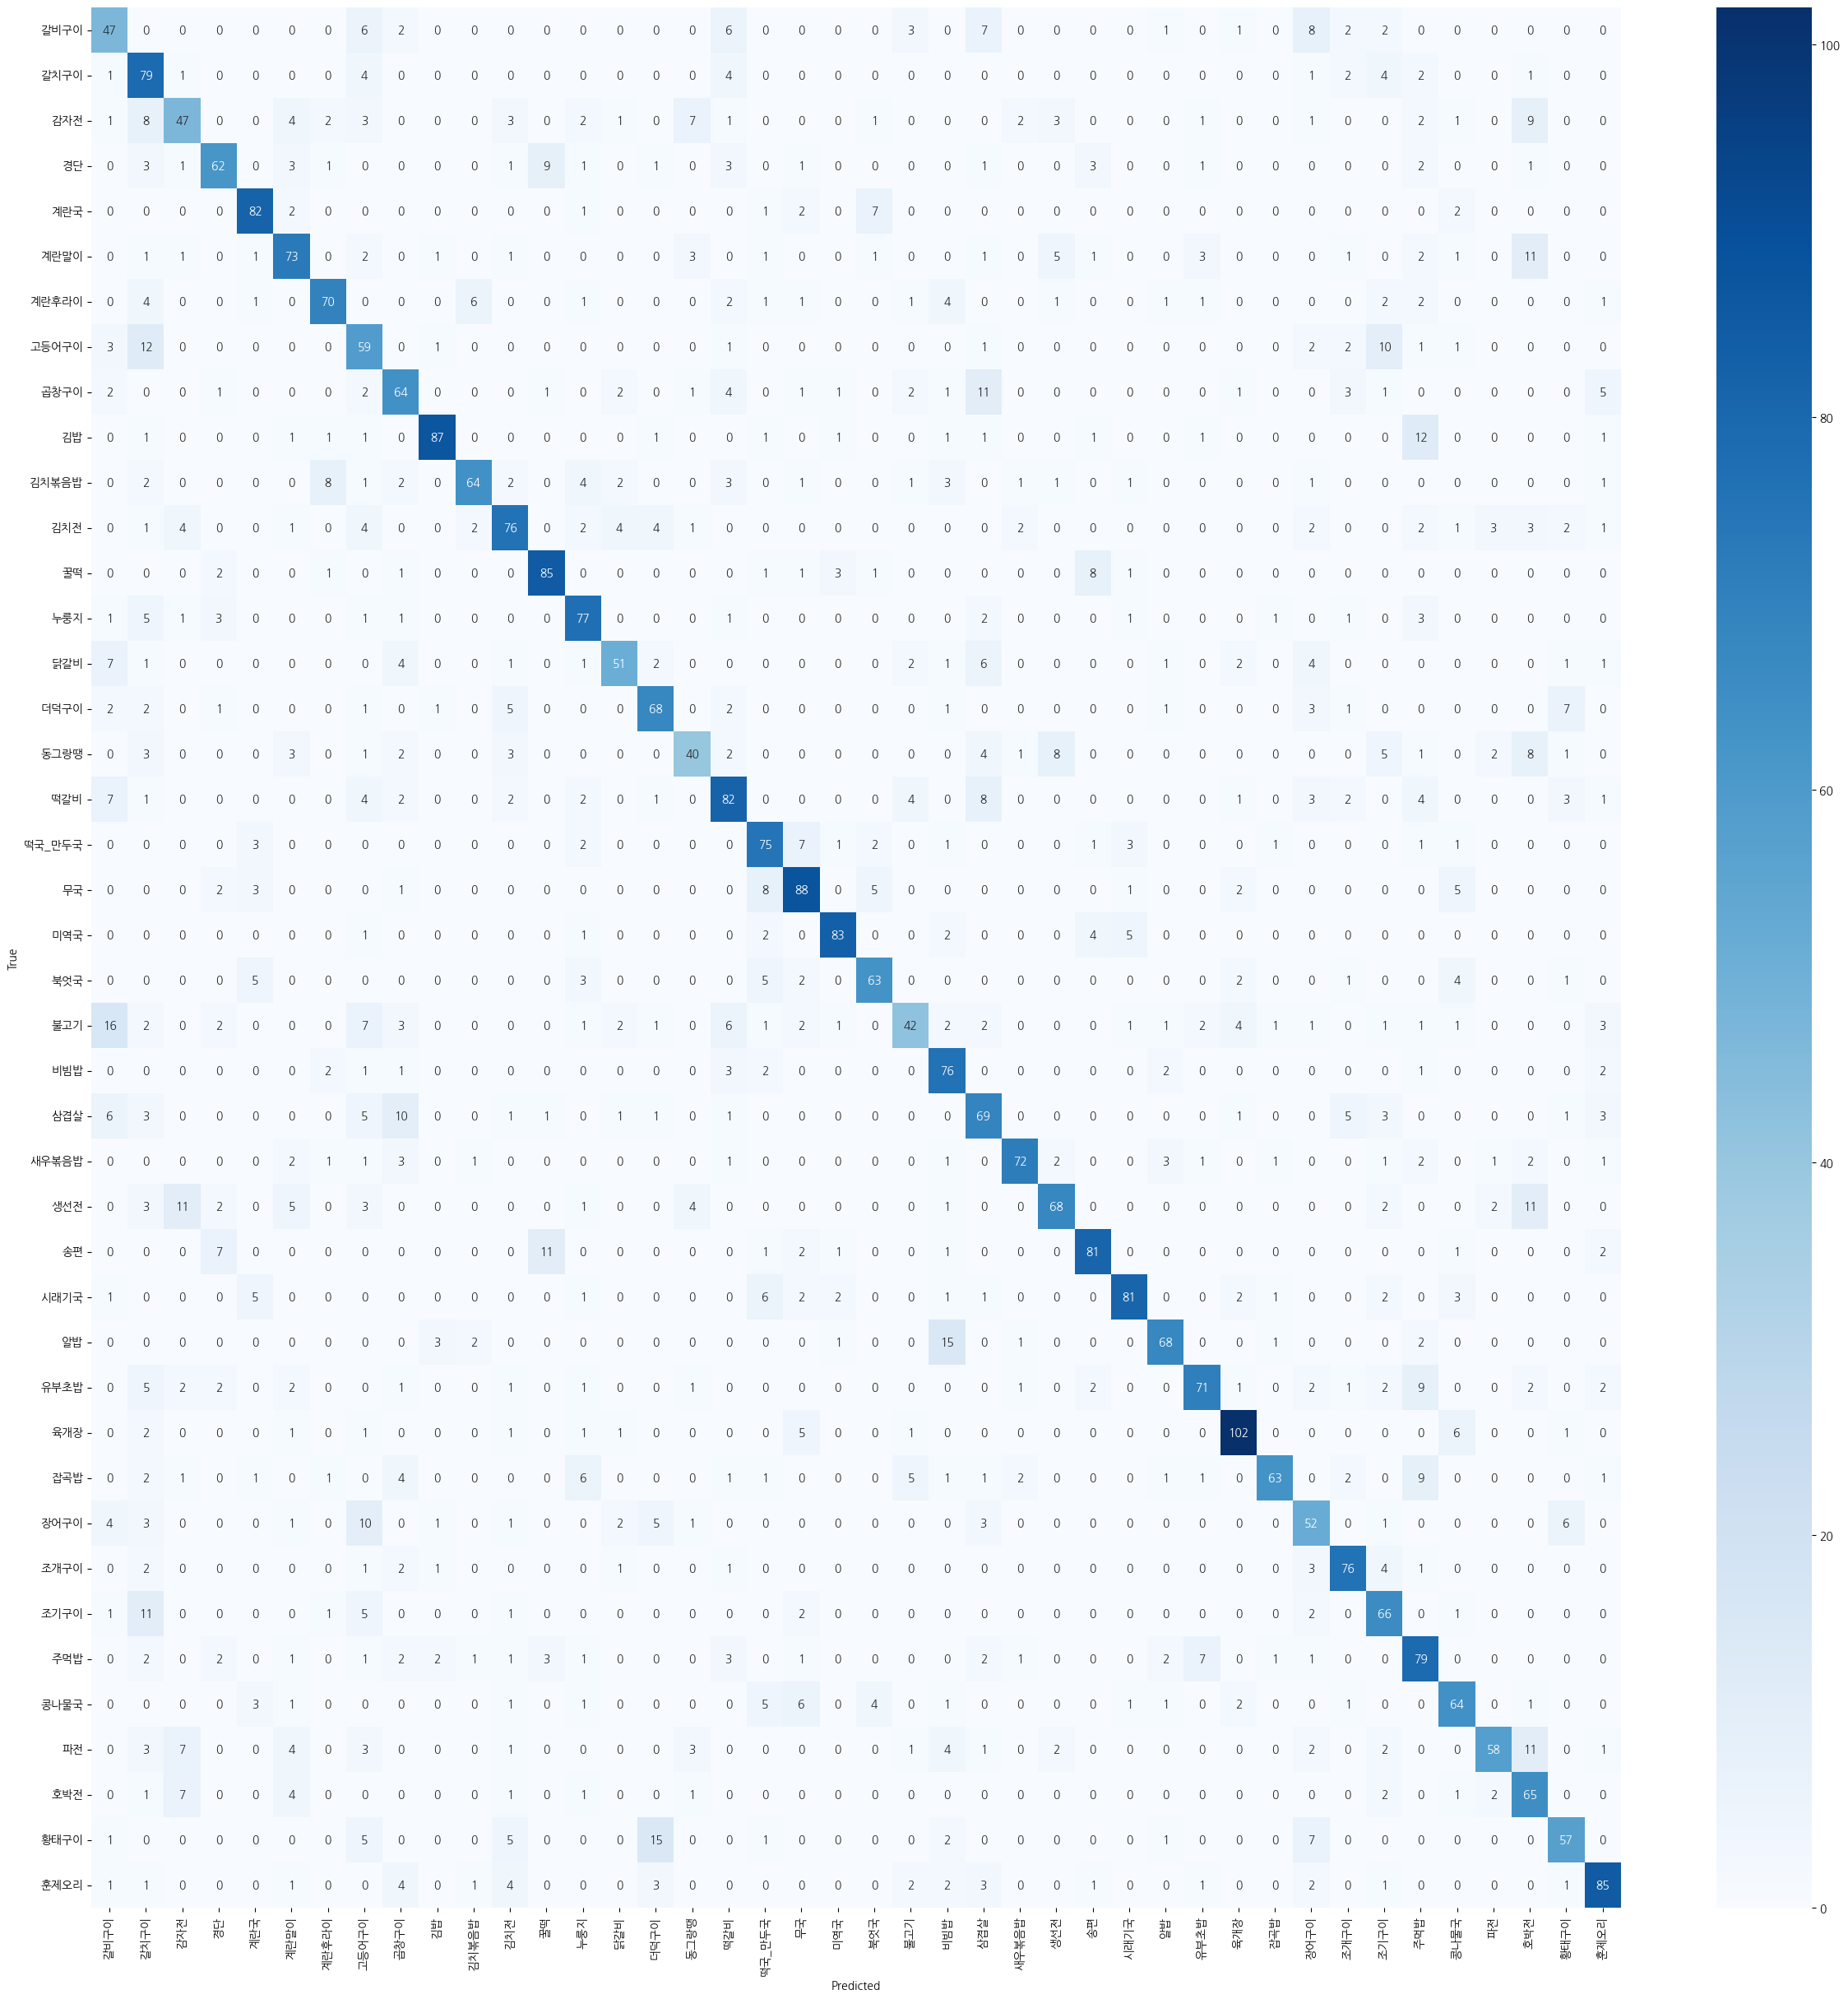

In [ ]:
save = temp_tensor.to('cpu')
metrix = list(np.array(save))
plt.figure(figsize = (30, 30))
for_heatmap = []
for i in label_list:
  for_heatmap.append(unicodedata.normalize('NFC',i))
sns.heatmap(metrix, annot=True, cmap='Blues',fmt='g',xticklabels=for_heatmap,yticklabels=for_heatmap)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
wandb.finish()

torch.Size([64, 3, 7, 7])


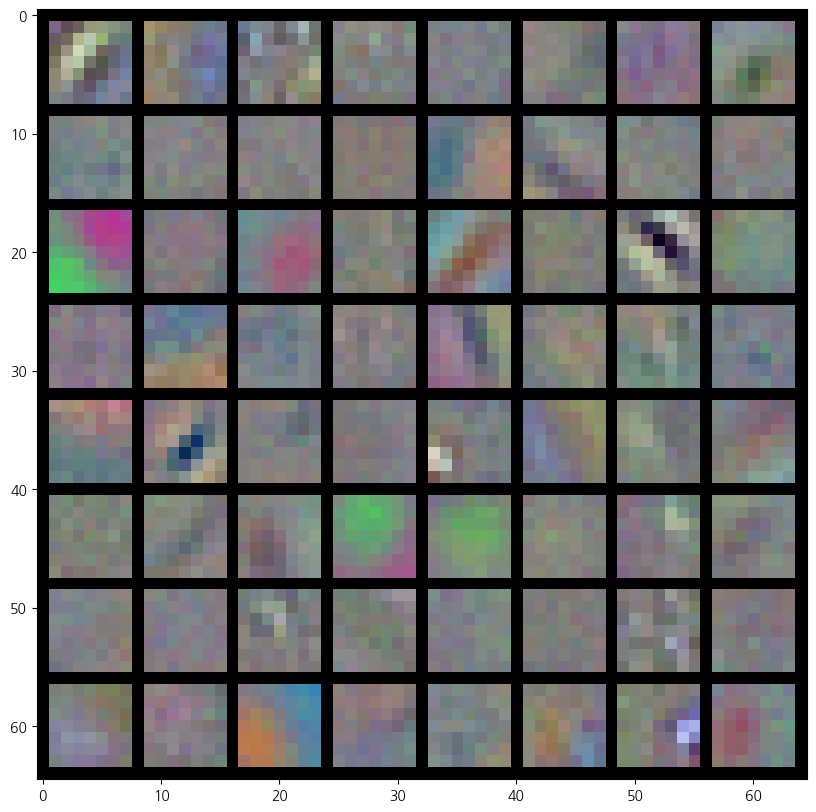

In [ ]:
for w in resnet.parameters():
  w = w.data.cpu()
  print(w.shape)
  break

min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = make_grid(x_grid, nrow=8, padding=1).permute(1,2,0)

plt.figure(figsize=(10,10))
plt.imshow(x_grid)
plt.show()

# for validation(no wandb)

In [3]:
PATH_resnet = './save_model/mission1.pt'

LOCAL = './val'

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/데이터셋
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/데이터셋
 ensemble.ipynb        validate_dist.ipynb
 good_model/           wandb/
 kfood_health_train/  '[대학부]딥러닝 모델 구현 실습 강채원.ipynb'
 kfood_health_val/     데이터개수세기.ipynb
 mission1.ipynb       '(실습파일) [대학부] CIFAR10_Augmentation.ipynb'
 mission2.ipynb       '(실습파일) [대학부] CIFAR10_Classification_ver0.ipynb'
 mission3.ipynb       '(실습파일) [대학부] CIFAR10_Classification_ver1.ipynb'
 save_model/          '(실습파일) [대학부] CIFAR10_Classification_ver2.ipynb'
 train/                이미지각화용.ipynb
 train_mean_std.npz    테스트용.ipynb
 val/                  평가용.ipynb


In [4]:
import os
from tqdm.notebook import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

from torch.backends import cudnn
cudnn.benchmark = True

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet = models.resnet18(pretrained=False)
fc_in_features = resnet.fc.in_features
resnet.fc = nn.Linear(fc_in_features,42)
resnet.load_state_dict(torch.load(PATH_resnet))
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
@torch.no_grad()
def validate_epoch(model: nn.Module, data_loader: DataLoader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.concat(accuracies).float().mean() * 100
    return accuracy.item()

In [11]:
meanR, meanG, meanB = 0.583938, 0.51390076, 0.4227201
stdR, stdG, stdB = 0.22708978, 0.2373795, 0.25375083

data_transform = T.Compose([T.Resize((224,224)),
                            T.ToTensor(),
                            T.Normalize(mean = [meanR, meanG, meanB], std = [stdR, stdG, stdB])])

data = ImageFolder(LOCAL,transform=data_transform)

#if error is here, you change num_workers
data_loader = DataLoader(data, batch_size=1,
                            shuffle=False, num_workers=128)

score = validate_epoch(resnet, data_loader, device)
print(score)

measuring accuracy:   0%|          | 0/4222 [00:00<?, ?it/s]

69.0904769897461
